# Fine tuning Azure Open AI Models for Data classification problem

In this notebook we will learn to fine tune Azure open AI models to perform a data classification.

For data classifiction using Open AI this notebook is divided into 3 sections

1. Load Data
2. Analysis
3. Data Preparation
4. Training
5. Validation
6. Model Deployment
7. Inference.

For the second half of the notebook we build a simple random forest classifier. 
We will also further develop insights into which models is recommended, cost implications, drawbacks of each. 


In [2]:
# Env variables
import os
import openai
from dotenv import load_dotenv
import openai
from openai import cli
import time
import numpy as np
from sklearn.datasets import load_files
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Azure
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_DEPLOYMENT_ENDPOINT = os.getenv("OPENAI_DEPLOYMENT_ENDPOINT")
OPENAI_DEPLOYMENT_NAME = os.getenv("OPENAI_DEPLOYMENT_NAME")
OPENAI_MODEL_NAME = os.getenv("OPENAI_MODEL_NAME")
OPENAI_EMBEDDING_DEPLOYMENT_NAME = os.getenv("OPENAI_EMBEDDING_DEPLOYMENT_NAME")
OPENAI_EMBEDDING_MODEL_NAME = os.getenv("OPENAI_EMBEDDING_MODEL_NAME")
OPENAI_DEPLOYMENT_VERSION = os.getenv("OPENAI_DEPLOYMENT_VERSION")
OPENAI_EMBEDDING_VERSION = os.getenv("OPENAI_EMBEDDING_VERSION")
AZURE_SUBSCRIPTION_ID = os.getenv("AZURE_SUBSCRIPTION_ID")

#init Azure OpenAI
openai.api_type = "azure"
openai.api_version = OPENAI_DEPLOYMENT_VERSION
openai.api_base = OPENAI_DEPLOYMENT_ENDPOINT
openai.api_key = OPENAI_API_KEY

## 1. Load Data

In this sample we will classify text that belong to 10 different categories like - technologie, sports, social etc.<br/>
The data can be downloaded from here https://drive.google.com/file/d/17vbWKQXFQu9qkOCps2z6Oi18ntT4FIuH/view?usp=sharing

In [3]:
# download data and name the folder as data.
if os.getcwd().endswith('data') == False:
    os.chdir("./data")

In [4]:
# load data from files
data = load_files(".", encoding="utf-8", decode_error="replace")

In [4]:
df = pd.DataFrame(list(zip(data['data'], data['target'])), columns=['text', 'label'])
# rename columns to meet the OpenAI requirements
df.rename(columns={'text':'prompt', 'label':'completion'}, inplace=True)
# convert label to string for padding
df.completion = df.completion.apply(lambda x : data.target_names[x])
df.head()

,prompt,completion
0,The future in your pocket\n\nIf you are a geek...,technologie
1,Brizzel to run AAA's in Sheffield\n\nBallymena...,sport
2,Fish and shellfish are both great sources of l...,food
3,JB> romdas@uclink.berkeley.edu (Ella I Baff) ...,medical
4,Tory leader unveils spending plan\n\nTory lead...,politics


In [5]:
num_of_classes = len(set(np.array(df.completion)))
print(f"Number of classes: {num_of_classes}")

Number of classes: 10


In [6]:
# files per class
df.groupby('completion').count()

,prompt
completion,
business,100
entertainment,100
food,100
graphics,100
historical,100
medical,100
politics,100
space,100
sport,100


## 2. Analysis 

In [15]:
# plot distribution of classes
df["num_of_words"] = df.prompt.apply(lambda x : len(x.split()))
df_graph = df['num_of_words'].groupby([df['completion']]).describe(percentiles=[0.95])
df_graph = df_graph.reset_index()
df_graph.sort_values(by=['max'], ascending=False).head(10)

,completion,count,mean,std,min,50%,95%,max
3,graphics,100.0,310.33,808.099942,21.0,192.0,546.70,8052.0
5,medical,100.0,435.62,940.705568,30.0,163.5,3079.15,4629.0
7,space,100.0,465.35,713.238572,19.0,190.5,1786.80,4033.0
4,historical,100.0,842.46,673.987148,82.0,704.0,2207.30,3082.0
6,politics,100.0,435.00,252.906498,142.0,418.5,614.35,2393.0
9,technologie,100.0,454.38,221.951937,67.0,433.0,886.25,1234.0
8,sport,100.0,316.62,194.286978,122.0,255.0,772.05,944.0
0,business,100.0,330.26,137.125956,147.0,298.0,598.05,891.0
1,entertainment,100.0,287.02,122.221440,152.0,244.5,549.35,806.0
2,food,100.0,226.47,85.220860,94.0,217.5,369.15,594.0


In [12]:
df.prompt[0].split(' ')

['The',
 'future',
 'in',
 'your',
 'pocket\n\nIf',
 'you',
 'are',
 'a',
 'geek',
 'or',
 'gadget',
 'fan,',
 'the',
 'next',
 '12',
 'months',
 'look',
 'like',
 'they',
 'are',
 'going',
 'to',
 'be',
 'a',
 'lot',
 'of',
 'fun.\n\nThe',
 'relentless',
 'pace',
 'of',
 'development',
 'in',
 'the',
 'hi-tech',
 'world',
 'and',
 'rampant',
 'competition',
 'in',
 'many',
 'of',
 'its',
 'sectors,',
 'particularly',
 'among',
 'mobile',
 'phone',
 'firms,',
 'all',
 'suggests',
 'that',
 '2005',
 'is',
 'going',
 'to',
 'be',
 'a',
 'very',
 'good',
 'year.',
 'To',
 'begin',
 'with,',
 '2005',
 'will',
 'be',
 'the',
 'year',
 'that',
 'third-generation',
 '(3G)',
 'mobile',
 'phones',
 'become',
 'inescapable.',
 'The',
 '3',
 'network',
 'launched',
 'in',
 '2003,',
 'Vodafone',
 'launched',
 'its',
 'consumer',
 'service',
 'in',
 'November,',
 'Orange',
 'followed',
 'in',
 'early',
 'December',
 'and',
 'T-Mobile',
 'and',
 'O2',
 'are',
 'due',
 'to',
 'launch',
 'in',
 '2005.

<Axes: title={'center': 'Max number of words per class'}, xlabel='completion'>

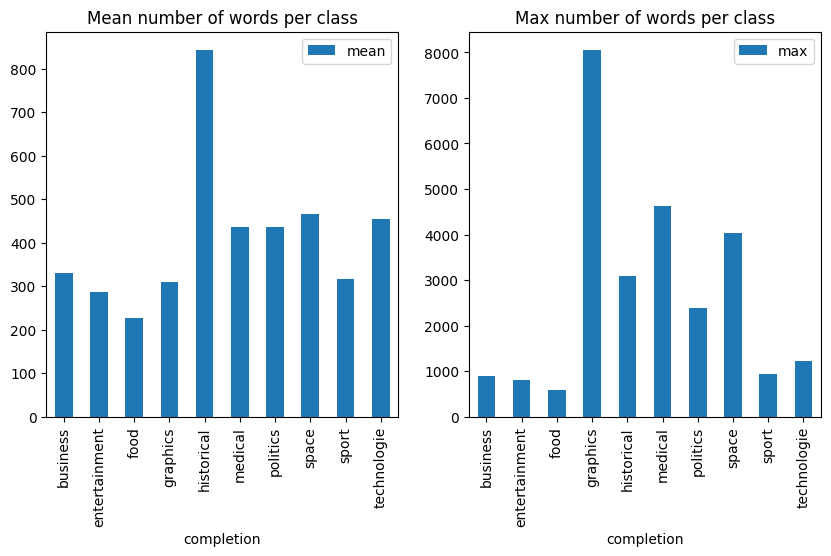

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2)
df_graph.plot(x='completion', y='mean', kind='bar', figsize=(10, 5), title='Mean number of words per class', ax=axes[0])
df_graph.plot(x='completion', y='max', kind='bar', figsize=(10, 5), title='Max number of words per class', ax=axes[1])


Key Insights
- Graphics category has the largest text followed by medical, space.
- Graphics is also skewed because min, max and 95% have huge variation
- Food category has lowest words.

## 3. Data Preparation

In [18]:
df = df.drop(columns=['num_of_words'])
# Each prompt should end with a fixed separator to inform the model when the prompt ends and the completion begins. 
# A simple separator which generally works well is \n\n###\n\n. The separator should not appear elsewhere in any prompt.
df.prompt = df.prompt + "\n\n###\n\n"
# Each completion should start with a whitespace due to tokenization, which tokenizes most words with a preceding whitespace.
df.completion = df.completion.apply(lambda x: " " + x)
df.prompt[0][-10:], df.completion[0]

('h.\n\n\n###\n\n', ' technologie')

In [74]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
print(df_train.shape)
print(df_test.shape)
df_train.head()

(800, 2)
(200, 2)


,prompt,completion
29,Winn-Dixie files for bankruptcy\n\nUS supermar...,business
535,In article <C5Kys1.C6r@panix.com> dannyb@panix...,space
695,In article <1993Apr14.174824.12295@westminster...,medical
557,------------- cut here -----------------\nUniv...,medical
836,Apple iPod family expands market\n\nApple has ...,technologie


In [20]:
# creating training files in JSONL format
training_file_name = "news_ds_train.jsonl"
test_file_name = "news_ds_test.jsonl"
df_train.to_json(training_file_name, orient='records', lines=True)
df_test.to_json(test_file_name, orient='records', lines=True)

In [21]:
# uploading the training files to Azure OpenAI Studio
training_id  = cli.FineTune._get_or_upload(training_file_name, False)
validation_id = cli.FineTune._get_or_upload(test_file_name, False)

Upload progress: 100%|██████████| 2.14M/2.14M [00:00<?, ?it/s]


Uploaded file from news_ds_train.jsonl: file-8ecdfd7090a948a7bebe9ae8be2a78cf


Upload progress: 100%|██████████| 534k/534k [00:00<00:00, 632Mit/s]


Uploaded file from news_ds_test.jsonl: file-72a3c29d5e8a48bf9c85882298745ba2


## 4. Training

In [23]:
# create a customized model with training and validation data. 
# The model will be trained for 1 epoch and will compute classification metrics.
create_args = {
    "training_file": training_id,
    "validation_file": validation_id,
    "model": "ada",
    "n_epochs": 1,
    "compute_classification_metrics": True,
    "classification_n_classes": num_of_classes
}

# Create the fine-tune job and retrieve the job ID
# and status from the response.
resp = openai.FineTune.create(**create_args)
job_id = resp["id"]
status = resp["status"]

# You can use the job ID to monitor the status of the fine-tune job.
# The fine-tune job may take some time to start and complete.
print(f'Fine-tuning model with job ID: {job_id}.')

Fine-tuning model with job ID: ft-748a702cd2f34e9bb4282c6915f9f9db.


In [27]:
status = openai.FineTune.retrieve(id=job_id)["status"]

# If the job isn't yet done, poll it every 2 seconds.
if status not in ["succeeded", "failed"]:
    print(f'Job not in terminal status: {status}. Waiting.')
    while status not in ["succeeded", "failed"]:
        time.sleep(10)
        status = openai.FineTune.retrieve(id=job_id)["status"]
        print(f'Status: {status}')
else:
    print(f'Fine-tune job {job_id} finished with status: {status}')


Job not in terminal status: notRunning. Waiting.
Status: notRunning
Status: notRunning
Status: notRunning
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: runnin

In [28]:
import io
# verify the trainining results
# Retrieve the fine-tune job
result = openai.FineTune.retrieve(id=job_id)
if result["status"] == 'succeeded':
    result_file_id = result.result_files[0].id
    result_file_name = result.result_files[0].filename
    result_validation_file_id = result.validation_files[0].id
print(f'Downloading result file: {result_file_name}')
with open(result_file_name, "wb") as file:
    result = openai.File.download(id=result_file_id)
    file.write(result)
print(f'Result file {result_file_name} downloaded.')

Result file results.csv downloaded.


In [29]:
result = openai.FineTune.retrieve(id=job_id)
total_tokens = result.training_files[0].statistics.tokens + result.validation_files[0].statistics.tokens
total_examples = result.training_files[0].statistics.examples + result.validation_files[0].statistics.examples
print(f'Total tokens: {total_tokens}')
print(f'Total examples: {total_examples}')

Total tokens: 412337
Total examples: 1000


## 5. Analysis

In [30]:
df_results = pd.read_csv('./results.csv')
df_results.tail(3)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,classification/accuracy,classification/weighted_f1_score
768,769,363025,769,0.250758,1,1.0,-1.00,-1.000000
769,770,364626,770,0.242178,1,1.0,-1.00,-1.000000
770,771,365403,771,0.257145,1,1.0,0.98,0.980127


Text(0.5, 1.0, 'Classification weighted F1 score')

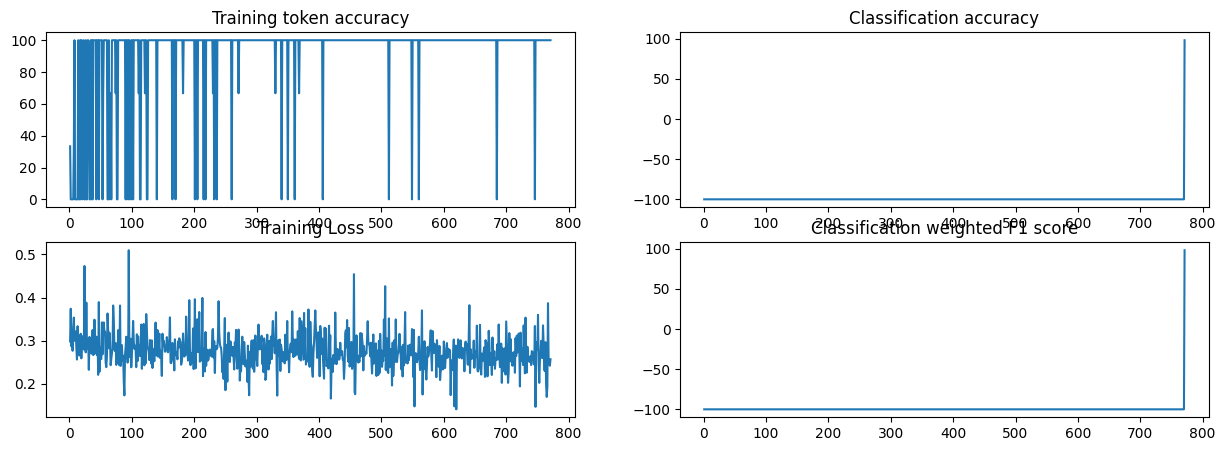

In [48]:
# Plotting training Loss
training_steps = np.array(df_results.step)
training_loss = np.array(df_results.training_loss)
training_token_accuracy = np.array(df_results.training_token_accuracy*100)
training_classification_accuracy = np.array(df_results["classification/accuracy"]*100)
training_classification_weighted_f1_score = np.array(df_results["classification/weighted_f1_score"]*100)


fig, axes = plt.subplots(2, 2, figsize=(15, 5))
axes[0,0].plot(training_steps, training_token_accuracy)
axes[0,0].set_title('Training token accuracy')
axes[0,1].plot(training_steps, training_classification_accuracy)
axes[0,1].set_title('Classification accuracy')
axes[1,0].plot(training_steps, training_loss)
axes[1,0].set_title('Training Loss')
axes[1,1].plot(training_steps, training_classification_weighted_f1_score)
axes[1,1].set_title('Classification weighted F1 score')


## 6. Model Deployment

The customized model is available for deployment only once. In the below step we will deploy the model, which makes it available for inference using Open AI Completion libraries.
Note: The code that is present online is deprecated. 

In [49]:
# Moving forward (Azure API versions 2023-05-15 and newer), the deployments APIs are deprecated in the openai library. 
# For all code managing deployments, it is recommended to use the azure-mgmt-cognitiveservices client library. 

from azure.mgmt.cognitiveservices import CognitiveServicesManagementClient
from azure.identity import AzureCliCredential

load_dotenv()

sub_id = os.getenv("AZURE_SUBSCRIPTION_ID")
rg_name = os.getenv("RESOURCE_GROUP_NAME")
acc_name = os.getenv("ACCOUNT_NAME")
deployment_name = os.getenv("DEPLOYMENT_NAME")
model_name = ""
model_version = os.getenv("MODEL_VERSION")
tenant_id = os.getenv("TENANT_ID")


result = openai.FineTune.retrieve(id=job_id)
if result["status"] == 'succeeded':
    model_name = result["fine_tuned_model"]

# DefaultAzureCredential supports different authentication mechanisms and determines the appropriate credential type based of the environment it is executing in.
client = CognitiveServicesManagementClient(credential=AzureCliCredential(tenant_id=tenant_id), subscription_id=sub_id)
deployment = client.deployments.begin_create_or_update(
    resource_group_name=rg_name,
    account_name=acc_name,
    deployment_name=deployment_name,
    deployment={
        "properties": {
          "model": {
            "format": "OpenAI",
            "name": model_name,
            "version": model_version
          },
          "scaleSettings": {
            "scaleType": "Standard"
          }
        }
    }
)
result = deployment.result()
print(result)

{'additional_properties': {}, 'id': '/subscriptions/6a01260f-39d6-415f-a6c9-cf4fd479cbec/resourceGroups/sriks-ml-rg/providers/Microsoft.CognitiveServices/accounts/prompt-eng-models/deployments/custom-classification', 'name': 'custom-classification', 'type': 'Microsoft.CognitiveServices/accounts/deployments', 'system_data': <azure.mgmt.cognitiveservices.models._models_py3.SystemData object at 0x000001DCB5E843D0>, 'etag': '"1c4c9a37-928c-4a35-9fac-333924692b2e"', 'properties': <azure.mgmt.cognitiveservices.models._models_py3.DeploymentProperties object at 0x000001DCB5E84D90>}


## 7. Prediction Score

In this section we will use the data from validation set to predict the target class.
Similar to fine-tuning, we should update the prompts with additional tokens for the model to accurately predict.
For classifictaion it is recommended to keep the temperature low. 

In [75]:
def get_completion(start_phrase):
    text = ""
    try:
        start_phrase = start_phrase + "\n\n###\n\n"
        response = openai.Completion.create(engine=result.name, prompt=start_phrase, max_tokens=1, temperature=0)
        text = response['choices'][0]['text'].replace('\n', '').replace(' .', '.').strip()
    except:
        return text
        # do nothing
    return text

df_test["predicted_class"] = df_test["prompt"].apply(get_completion)
df_test.head(3)

,prompt,completion,predicted_class
521,Tate & Lyle boss bags top award\n\nTate & Lyle...,business,business
737,Weak end-of-year sales hit Next\n\nNext has sa...,business,business
740,rind@enterprise.bih.harvard.edu (David Rind) w...,medical,


In [76]:
# the following code is used to remove the empty predicted_class rows
# this can happen if the model is not able to generate a response for a given prompt due to the max_tokens limit or content filtering
print(f'Number of rows with empty predicted_class: {len(df_test[df_test["predicted_class"] == ""])}')
# remove the empty rows
df_test = df_test[df_test["predicted_class"] != ""]
df_test.predicted_class.value_counts()

Number of rows with empty predicted_class: 18


predicted_class
business         27
medical          25
sport            20
space            20
food             19
techn            18
politics         17
entertainment    16
graphics         13
historical        7
Name: count, dtype: int64

In [95]:
target_names = df_test.completion.unique()
df_test = df_test[df_test["predicted_class"] != ""]
df_test.completion = df_test.completion.apply(lambda x: x.replace('\n', '').replace(' .', '.').strip())
accuracy = accuracy_score(df_test["completion"], df_test["predicted_class"])
print(f'Accuracy: {round(accuracy*100,2)}')

Accuracy: 87.91


In [96]:
df_test[df_test["completion"] != df_test["predicted_class"]].head(10)

,prompt,completion,predicted_class
280,Wi-fi web reaches farmers in Peru\n\nA network...,technologie,techn
883,"Yahoo celebrates a decade online\n\nYahoo, one...",technologie,techn
761,"Creator of first Apple Mac dies\n\nJef Raskin,...",technologie,techn
549,Xbox power cable 'fire fear'\n\nMicrosoft has ...,technologie,techn
947,"In article <1993Apr20.125920.15005@ircam.fr>, ...",medical,space
370,Security scares spark browser fix\n\nMicrosoft...,technologie,techn
296,Mobiles rack up 20 years of use\n\nMobile phon...,technologie,techn
209,Sony PSP tipped as a 'must-have'\n\nSony's Pla...,technologie,techn
866,Am I justified in being pissed off at this doc...,medical,space
764,Game firm holds 'cast' auditions\n\nVideo game...,technologie,techn


# Random Forest Classifier

In this section we will build a random forest classifier for the same dataset.

In [5]:
# Import packages required for building Random Forest Classifier
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import layers
from sklearn.feature_extraction.text import TfidfVectorizer

### 1. Data Preparation

In [6]:
df = pd.DataFrame(list(zip(data['data'], data['target'])), columns=['text', 'label'])
df.label = df.label.apply(lambda x: df['label'][x])
tfdf = TfidfVectorizer(max_features=10000)
df.text = tfdf.fit_transform(df.text).toarray().tolist()
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train.head(2)

,text,label
29,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9
535,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2


### 2. Model Development

In [7]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(df_train.text.tolist(), df_train.label.tolist())

RandomForestClassifier(n_estimators=1000, random_state=0)

### 3. Prediction Score

In [8]:
df_test["predictions"] = classifier.predict(df_test.text.tolist()) 

In [9]:
accuracy = accuracy_score(df_test.label.tolist(), df_test.predictions.tolist())
print(f'Accuracy: {round(accuracy*100,2)}')

Accuracy: 91.5


In [13]:
# Print the first 10 rows where the predicted class is different from the actual class
df_test[df_test["label"] != df_test["predictions"]].head(5)

,text,label,predictions
811,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0
947,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9,2
277,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9,2
570,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,2
209,"[0.0, 0.03481925931891204, 0.0, 0.0, 0.0, 0.0,...",7,8


In [16]:
import joblib
joblib.dump(classifier, "./random_forest.joblib", compress=3)
print(f"Compressed Random Forest: {np.round(os.path.getsize('random_forest.joblib') / 1024 / 1024, 2) } MB")

Compressed Random Forest: 7.23 MB


## Summary

- Open AI models can be fine tuned for data classification, however they are time consuming and costlier than simpler models like random forests.
- Open AI models can halluciate and produce incorrect labels which do not exist.
- Simple models perform better than Open AI models.
- Simple models are small and easily portable

In [2]:
%pip install tensorflow-decision-forests

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow-decision-forests (from versions: none)
ERROR: No matching distribution found for tensorflow-decision-forests
